# Exercise 1: Python and sounds

This exercise aims to get familiar with some basic audio operations using Python. There are four parts to it: 1) Reading an audio file, 2) Basic operations with audio, 3) Python array indexing, and 4) Downsampling audio - Changing the sampling rate.

### Relevant concepts

__sms-tools:__ . Sound analysis/synthesis tools for music applications written in python (with a bit of C). Available at https://github.com/MTG/sms-tools. They can be installed as a python package with `pip install sms-tools`. Materials associated with the tools are in https://github.com/MTG/sms-tools-materials.

__Python:__ Python is a powerful and easy to learn programming language, which is used in a wide variety of application areas. More information in https://www.python.org/. We will use python in all the exercises and in this first one you will start learning about it by performing some basic operations with sound files.

__Jupyter notebooks:__ Jupiter notebooks are interactive documents containing live code, equations, visualizations and narrative text. More information in https://jupyter.org/. It supports Python and all the exercises here use it.

__Wav file:__ The wav file format is a lossless format to store sounds on a hard drive. Each audio sample is stored as a 16 bit integer number (sometimes also as 24 bit integer or 32 bit float). In this course we will work with only one type of audio files. All the sound files we use in the assignments should be wav files that are mono (one channel), in which the samples are stored in 16 bits, and that use (most of the time) the sampling rate of 44100 Hz. Once read into python, the samples will be converted to floating point values with a range from -1 to 1, resulting in a one-dimensional array of floating point values.

## Part 1 - Reading in an audio file
Write a function that reads an audio file and returns 10 consecutive samples of the file starting from
the 50001th sample. This means that the output should exactly contain the 50001th sample to the 50010th
sample (10 samples).

The input to the function is the file name (including the path), plus the location of first sample and the number of consecutive samples to take, and the output should be a numpy array.

If you use the `wavread()` function from the `utilFunctions` module available in `sms-tools`, the input samples will be automatically converted to a numpy array of floating point numbers with a range from -1 to 1, which is what we want.

Remember that in python, the index of the first sample of an array is 0 and not 1.

In [4]:
#if want to run this notebook in google colab you should uncomment the following commands
#!pip install sms-tools
#!git clone https://github.com/MTG/sms-tools-materials.git

In [2]:
import numpy as np
from smstools.models.utilFunctions import wavread
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import resample_poly

In [46]:
# E1 - 1.1: Complete the read_audio_samples() function

def readAudio(input_file, first_sample=50001, num_samples=10):
    """Read num_samples samples from an audio file starting at sample first_sample

    Args:
        input_file (str): path of a wav file

    Returns:
        np.array: numpy array containing the selected samples

    """

    return wavread(input_file)[1][first_sample - 1:first_sample - 1 + num_samples]

### Audio Normalization Factor 
I noticed that the results are not the same as test output, and I compared the older implementations of wavread. I saw that normalization factor of int16 could be different:

```
1. Division by 2^15−1 (32,767)

    Resulting Range: ≈[−1.00003,+1.0]

    Key Consequence: Guarantees that the positive peak of the signal is mapped exactly to +1.0 (the digital limit or 0 dBFS).

    Recommendation: Yes, this is the standard practice in audio processing.

2. Division by 2^15 (32,768)

    Resulting Range: [−1.0,≈+0.99997]

    Key Consequence: The positive peak never reaches 1.0 (the signal is slightly attenuated or "sub-normalized").

    Recommendation: No, the method above is preferred to maximize amplitude.

Summary: For 16-bit audio, dividing by 215−1 (32,767) is recommended to ensure the digital peak point is exactly +1.0.

Source: Gemini
```

In [47]:
def readAudiov2(input_file, first_sample=50001, num_samples=10):
    """Read num_samples samples from an audio file starting at sample first_sample

    Args:
        input_file (str): path of a wav file
    
    Returns:
        np.array: numpy array containing the selected samples

    """
    
    signal = read(input_file)[1] / (2**15 - 1)
    return np.array(signal[first_sample - 1:first_sample - 1 + num_samples], dtype=np.float32)

### Tests

You can use as input the sound files from the sounds directory, thus using a relative path to it. If you run the `readAudio()` function using the `piano.wav` sound file as input, with the default arguments, it should return the following samples:
```
array([-0.06213569, -0.04541154, -0.02734458, -0.0093997, 0.00769066, 0.02319407, 0.03503525, 0.04309214, 0.04626606,  0.0441908], dtype=float32)
```

In [48]:
# E1 - 1.2: Call read_audio_samples() with the proposed input sound and default arguments
test = np.array([-0.06213569, -0.04541154, -0.02734458, -0.0093997, 0.00769066, 0.02319407, 0.03503525, 0.04309214, 0.04626606,  0.0441908], dtype=np.float32)
audio = readAudio('../sounds/piano.wav')

if np.isclose(audio, test).all():
    print("E1 - 1.2: Correct\n" + str(audio))
else:
    print("E1 - 1.2: Incorrect\n" + str(audio) + " vs " + str(test))

E1 - 1.2: Incorrect
[-0.06213379 -0.04541016 -0.02734375 -0.00939941  0.00769043  0.02319336
  0.03503418  0.04309082  0.04626465  0.04418945] vs [-0.06213569 -0.04541154 -0.02734458 -0.0093997   0.00769066  0.02319407
  0.03503525  0.04309214  0.04626606  0.0441908 ]


In [49]:
audio = np.array(readAudiov2('../sounds/piano.wav'), dtype=np.float32)

if np.isclose(audio, test).all():
    print("E1 - 1.2 v2: Correct\n" + str(audio))
else:
    print("E1 - 1.2 v2: Incorrect\n" + str(audio) + " vs " + str(test))

E1 - 1.2 v2: Correct
[-0.06213569 -0.04541154 -0.02734458 -0.0093997   0.00769066  0.02319407
  0.03503525  0.04309214  0.04626606  0.0441908 ]


## Part 2 - Basic operations with audio

The function `minMaxAudio()` should read an audio file and return the minimum and  maximum values of the audio samples in that file. The input to the function is the wav file name (including the path) and the output should be two floating point values returned as a tuple.

In [50]:
# E1 - 2.1: Complete function minMaxAudio()

def min_max_audio(input_file):
    """Compute the minimum and maximum values of the audio samples in the input file

    Args:
        inputFile(str): file name of the wav file (including path)

    Returns:
        tuple: minimum and maximum value of the audio samples, like: (min_val, max_val)
    """
    samples = wavread(input_file)[1]
    return (np.min(samples), np.max(samples))


In [51]:
def min_max_audiov2(input_file):
    """Compute the minimum and maximum values of the audio samples in the input file

    Args:
        inputFile(str): file name of the wav file (including path)

    Returns:
        tuple: minimum and maximum value of the audio samples, like: (min_val, max_val)
    """
    samples = read(input_file)[1] / (2**15 - 1)
    return (np.min(samples), np.max(samples))

### Tests

If you run `min_max_audio()` using `oboe-A4.wav` as input, it should return the following output:

```
(-0.83486432, 0.56501967)
```

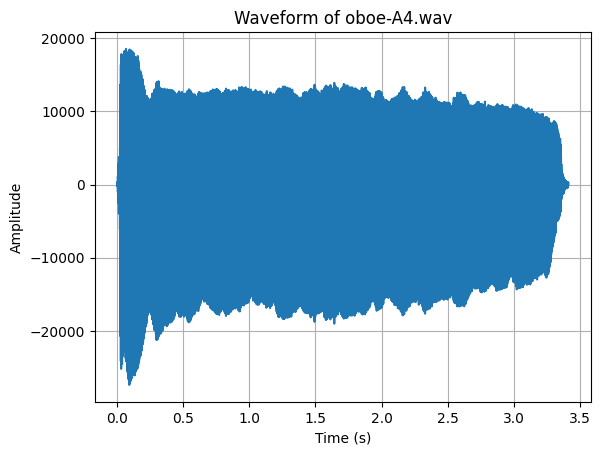

E1 - 2.2: Incorrect
(-0.83483887, 0.56500244) vs (-0.83486432, 0.56501967)
E1 - 2.2 v2: Correct
(-0.8348643452253792, 0.5650196844386121)


In [61]:
# E1 - 2.2: Plot input sound with x-axis in seconds, and call min_max_audio() with the proposed sound file
test = (-0.83486432, 0.56501967)
audio = read('../sounds/oboe-A4.wav')

plt.plot(np.arange(len(audio[1])) / audio[0], audio[1]) # Length of audio divided by sample rate to get time in seconds
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of oboe-A4.wav')
plt.grid()
plt.show()

min, max = min_max_audio('../sounds/oboe-A4.wav')
if np.isclose((min, max), test).all():
    print("E1 - 2.2: Correct\n" + str((min, max)))
else:
    print("E1 - 2.2: Incorrect\n" + str((min, max)) + " vs " + str(test))

min, max = min_max_audiov2('../sounds/oboe-A4.wav')
if np.isclose((min, max), test).all():
    print("E1 - 2.2 v2: Correct\n" + str((min, max)))
else:
    print("E1 - 2.2 v2: Incorrect\n" + str((min, max)) + " vs " + str(test))

## Part 3 - Python array indexing

For the function `hop_samples()`, given a numpy array `x`, it should return every Mth element of `x`, starting from the first element. The input arguments to this function are a numpy array `x` and a positive integer `M` such that `M` < number of elements in `x`. The output of this function should be a numpy array.

In [15]:
# E1 - 3.1: Complete the function hop_samples()

def hop_samples(x, M):
    """Return every Mth element of the input array

    Args:
        x(np.array): input numpy array
        M(int): hop size (positive integer)

    Returns:
        np.array: array containing every Mth element in x, starting from the first element in x
    """
    if M <= 0 or not isinstance(M, int):
        raise ValueError("M must be a positive integer")
    return x[::M]


If you run the function`hop_samples()` with `x = np.arange(10)` and `M = 2` as inputs, it should return:

```
array([0, 2, 4, 6, 8])
```

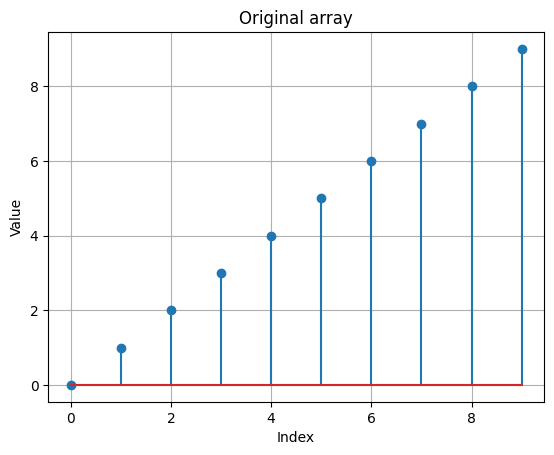

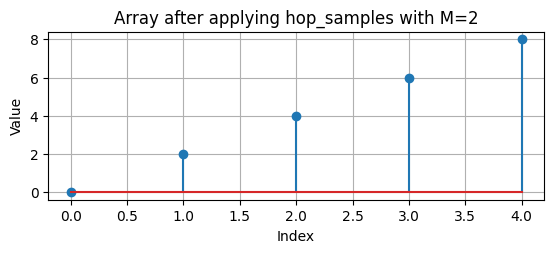

In [69]:
# E1 - 3.2: Plot input array, call hop_samples() with proposed input, and plot output array

x = np.arange(10)
plt.subplot(1, 1, 1)
plt.stem(x)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original array')
plt.grid()
plt.show()

x = hop_samples(x, 2)
plt.subplot(2, 1, 2)
plt.stem(x)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Array after applying hop_samples with M=2')
plt.grid()
plt.show()

## Part 4 - Downsampling


One of the required processes to represent an analog signal inside a computer is sampling. The sampling rate is the number of samples obtained in one second when sampling a continuous analog signal to a discrete digital signal. As mentioned we will be working with wav audio files that have a sampling rate of 44100 Hz, which is a typical value. Here you will learn a simple way of changing the original sampling rate of a sound to a lower sampling rate, and will learn the implications it has in the audio quality.

The function `down_sample_audio()` has as input an audio file with a given sampling rate, it should apply downsampling by a factor of `M` and return a down-sampled version of the input samples. The sampling rates and downsampling factors to use have to be integer values.

From the output samples if you need to create a wav audio file from an array, you can use the `wavwrite()` function from the `utilFunctions.py` module. However, in this exercise there is no need to write an audio file, we will be able to hear the sound without creating a file, just playing the array of samples.

### Design of Downsampling

Rate reduction by an integer factor M can be explained as a two-step process, with an equivalent implementation that is more efficient:

    1. Reduce high-frequency signal components with a digital lowpass filter.
    2. Decimate the filtered signal by M; that is, keep only every Mth sample.

Without applying the antialising filter, the downsampled signal could be distorted.
Scipy funtion resample_poly is a good implementation for that.

In [24]:
# E1 - 4.1: Complete function down_sample_audio()

def down_sample_audio(input_file, M):
    """Downsample by a factor of M the input signal

    Args:
        input_file(str): file name of the wav file (including path)
        M(int): downsampling factor (positive integer)

    Returns:
        tuple: input samples (np.array), original sampling rate (int), down-sampled signal (np.array),
               and new sampling rate (int), like: (x, fs, y, fs_new)
    """
    if M <= 0 or not isinstance(M, int):
        raise ValueError("M must be a positive integer")
    
    fs, x = wavread(input_file)
    y = hop_samples(x, M)
    fs_new = fs // M
    return (x, fs, y, fs_new)

In [25]:
def down_sample_audiov2(input_file, M):
    """Downsample by a factor of M the input signal using resample_poly to avoid aliasing

    Args:
        input_file(str): file name of the wav file (including path)
        M(int): downsampling factor (positive integer)

    Returns:
        tuple: input samples (np.array), original sampling rate (int), down-sampled signal (np.array),
               and new sampling rate (int), like: (x, fs, y, fs_new)
    """
    if M <= 0 or not isinstance(M, int):
        raise ValueError("M must be a positive integer")
    
    fs, x = read(input_file)
    x = x / (2**15 - 1)
    y = resample_poly(x, up=1, down=M, axis=0) # Better way to downsample to avoid aliasing (fs_new = fs * up / down)
    fs_new = fs // M
    return (x, fs, y, fs_new)

Test cases for `down_sample_audio()`:

_Test Case 1:_ Use the file from the sounds directory `vibraphone-C6.wav` and a downsampling factor of `M=14`.

_Test Case 2:_ Use the  file from the sounds directory `sawtooth-440.wav` and a downsampling factor of `M=14`.

To play the output samples, import the `Ipython.display` package and use `ipd.display(ipd.Audio(data=y, rate=fs_new))`. To visualize the output samples import the `matplotlib.pyplot` package and use `plt.plot(x)`.

You can find some related information in https://en.wikipedia.org/wiki/Downsampling_(signal_processing)

In [20]:
def plot_audio(x, fs, title):
    """Plot audio signal x with sampling frequency fs and title
     Args:
         x(np.array): input audio signal
         fs(int): sampling frequency
         title(str): title of the plot
    """
    plt.figure(figsize=(5, 2))
    plt.plot(np.arange(len(x)) / fs, x)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

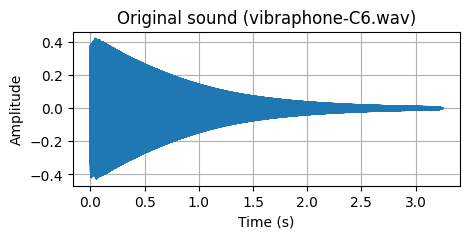

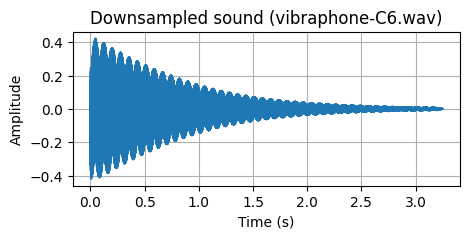

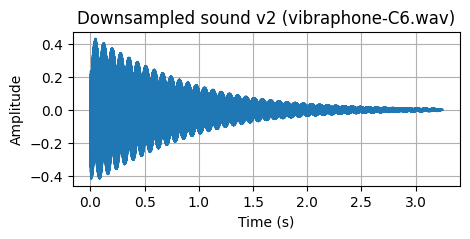

In [ ]:
# E1 - 4.2: Plot and play input sounds, call the function down_sample_audio() for the two test cases,
# and plot and play the output sounds.

# Original sound
vibraphone_audio = wavread('../sounds/vibraphone-C6.wav')
plot_audio(vibraphone_audio[1], vibraphone_audio[0], 'Original sound (vibraphone-C6.wav)')
ipd.display(ipd.Audio(data=vibraphone_audio[1], rate=vibraphone_audio[0]))

# First version of the downsampling function (without anti-aliasing)
vibraphone_result = down_sample_audio('../sounds/vibraphone-C6.wav', 14)
plot_audio(vibraphone_result[2], vibraphone_result[3], 'Downsampled sound (vibraphone-C6.wav)')
ipd.display(ipd.Audio(data=vibraphone_result[2], rate=vibraphone_result[3]))

# Second version of the downsampling function (with anti-aliasing)
vibraphone_result_v2 = down_sample_audiov2('../sounds/vibraphone-C6.wav', 14)
plot_audio(vibraphone_result_v2[2], vibraphone_result_v2[3], 'Downsampled sound v2 (vibraphone-C6.wav)')
ipd.display(ipd.Audio(data=vibraphone_result_v2[2], rate=vibraphone_result_v2[3]))

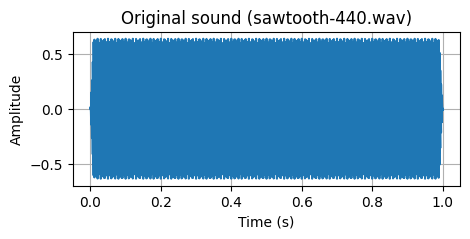

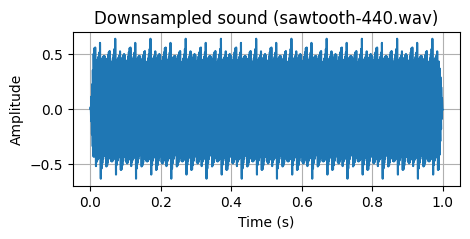

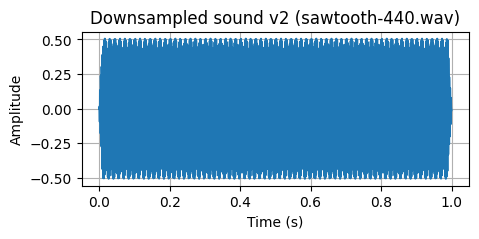

In [27]:
# Original sound
sawtooth_audio = wavread('../sounds/sawtooth-440.wav')
plot_audio(sawtooth_audio[1], sawtooth_audio[0], 'Original sound (sawtooth-440.wav)')
ipd.display(ipd.Audio(data=sawtooth_audio[1], rate=sawtooth_audio[0]))

# First version of the downsampling function (without anti-aliasing)
sawtooth_result = down_sample_audio('../sounds/sawtooth-440.wav', 14)
plot_audio(sawtooth_result[2], sawtooth_result[3], 'Downsampled sound (sawtooth-440.wav)')
ipd.display(ipd.Audio(data=sawtooth_result[2], rate=sawtooth_result[3]))

# Second version of the downsampling function (with anti-aliasing)
sawtooth_result_v2 = down_sample_audiov2('../sounds/sawtooth-440.wav', 14)
plot_audio(sawtooth_result_v2[2], sawtooth_result_v2[3], 'Downsampled sound v2 (sawtooth-440.wav)')
ipd.display(ipd.Audio(data=sawtooth_result_v2[2], rate=sawtooth_result_v2[3]))

**Questions: (answer here)**

 E1 - 4.3: Explain the results of part 4. What happened to the output signals compared to the input ones? Is there a difference between the 2 cases? Why? How could we avoid damaging the signal when downsampling it?

 When downsampling both inputs, the first thing we hear is a decrease in the quality of both audio tracks. However, the sawtooth audio sounds much worse than the vibraphone audio, with much more noise. This is due to aliasing, which occurs when we downsample audio without filtering the highest notes, as these become noise if not filtered.

 The lower susceptibility of the C6 vibraphone note to aliasing compared to a 440 Hz sawtooth wave stems from the profound difference in their harmonic content (or timbre), sawtooth has more High-Energy Harmonics (high frequencies). Aliasing is primarily caused by high-frequency components in the signal that exceed the new Nyquist frequency (> new_rate/2) after downsampling.

To avoid damage, we must adhere to the two-step process:

    1. Filtering: Apply an Anti-Aliasing LPF to the original signal. The filter's cutoff must be set below the new Nyquist limit.

    2. Decimate ("diezmado"): Only after filtering is it safe to discard samples (subsample) by a factor of Q.

For the implementation I used an optimized function of this algorithm, scipy.signal.resample_poly, which handles both filtering and decimation correctly.